## Importing Libraries

In [1]:
import warnings
warnings.filterwarnings(action='once')

#!pip install feature_engine
#!pip install --upgrade scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, precision_recall_curve, auc, f1_score, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.tree import  export_graphviz
from sklearn.feature_selection import SelectFromModel
import graphviz

from feature_engine.encoding import OneHotEncoder
from feature_engine import transformation as vt
from feature_engine.wrappers import SklearnTransformerWrapper

import scipy.stats as st
import statsmodels.api as sm

from imblearn.over_sampling import SMOTE

C:\Users\vxk200033\Anaconda3\lib\site-packages\patsy\constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Mapping


## Importing Dataset

In [2]:
df = pd.read_csv("Customer_Churn.csv")

In [3]:
print(df.columns)
print(df.shape)

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')
(7043, 21)


*This dataset contains data of 7043 customers and their attributes. We have demographics data of customers like gender, age range, senior citizen and if the customers have partners and dependents. We also have data about customer's association with the company, like tenure, if they use phone service and have multiple lines, if the customer uses services like Internet Service, Online security, Online Backup, Device Protection, Tech Supprt, Streaming TV and Movies. Finance related information includes type of contract, if the customer has opted for Paperless Billing, their payment method, monthly charges and total charges. The class/target variable is this dataset is Churn which classifies customers as yes if they are no more associated with the company.<br>
We have some very useful attributes about customers to predict customer churn. For example,<br>
Monthly charges - If the monthly charges are very high, customer might want to switch to another provider.<br>
Contract - If the customers are on short term contract, they are more likely to switch to another provider. If they are long-term contract they would tend to stay with the provider.<br>*

## Exploratory Data Analysis

### Taking a sample of 5 observations

In [4]:
df.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
6145,5010-IPEAQ,Female,0,Yes,Yes,67,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),54.20,3623.95,No
2585,9624-EGDEQ,Female,0,No,No,37,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.80,813.3,No
2584,3969-JQABI,Female,0,Yes,No,58,Yes,No,DSL,Yes,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),65.25,3791.6,No
6866,0295-PPHDO,Male,0,No,No,1,Yes,Yes,Fiber optic,No,...,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,95.45,95.45,Yes
6365,8884-ADFVN,Male,1,Yes,No,7,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,101.95,700.85,Yes


In [5]:
df.shape

(7043, 21)

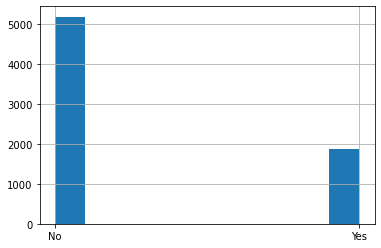

In [6]:
df['Churn'].hist()
plt.show()

*We can see there is an class imbalance in the dependent variable.*

### Preprocessing

*For our analysis we will not require customerID column. Dropping the column.*<br>

In [7]:
df.drop(columns=['customerID'], inplace=True)

In [8]:
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [9]:
for var in df.columns:
    print(f"\nNumber of unique values in {var}: {df[var].nunique()}")
    print(df[var].unique())


Number of unique values in gender: 2
['Female' 'Male']

Number of unique values in SeniorCitizen: 2
[0 1]

Number of unique values in Partner: 2
['Yes' 'No']

Number of unique values in Dependents: 2
['No' 'Yes']

Number of unique values in tenure: 73
[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]

Number of unique values in PhoneService: 2
['No' 'Yes']

Number of unique values in MultipleLines: 3
['No phone service' 'No' 'Yes']

Number of unique values in InternetService: 3
['DSL' 'Fiber optic' 'No']

Number of unique values in OnlineSecurity: 3
['No' 'Yes' 'No internet service']

Number of unique values in OnlineBackup: 3
['Yes' 'No' 'No internet service']

Number of unique values in DeviceProtection: 3
['No' 'Yes' 'No internet service']

Number of unique values in TechSupport: 3
['No' 'Yes' 'No internet serv

*We will change values of some columns to better readability and some values seems redundant like in TechSupport No internet service actually means customer has not availed Tech Support. Since we already have observations with No in Internet Service Column, we will replace these values with No.*

In [10]:
df.replace({'Month-to-month':'Monthly', 
            'Electronic check':'Electronic',
            'Mailed check':'Mailed',
            'Bank transfer (automatic)':'Bank transfer',
            'Credit card (automatic)':'Credit card', 
            'No internet service': 'No',
            'No phone service': 'No'
           }, inplace=True)

*We can see that SeniorCitizen is of type* ***int***, *we will change the data type to* ***category.***<br>
*Total charges is of type* ***object***, *we will change the data type to* ***float*** *by converting it to numeric values*.<br>
*We will also change all the columns with* ***object*** *data type to* ***category*** *data type*<br>
*There doesn't seem to be any variable which is of* ***ordinal*** *type*

In [11]:
df['SeniorCitizen'] = df['SeniorCitizen'].astype('category')

In [12]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [13]:
objCols = [var for var in df.columns if df[var].dtype == 'object']
objCols

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

In [14]:
for cols in objCols:
    df[cols] = df[cols].astype('category')
df.dtypes

gender              category
SeniorCitizen       category
Partner             category
Dependents          category
tenure                 int64
PhoneService        category
MultipleLines       category
InternetService     category
OnlineSecurity      category
OnlineBackup        category
DeviceProtection    category
TechSupport         category
StreamingTV         category
StreamingMovies     category
Contract            category
PaperlessBilling    category
PaymentMethod       category
MonthlyCharges       float64
TotalCharges         float64
Churn               category
dtype: object

### Divide variables into quantitative and qualitative

In [15]:
qual_var = [var for var in df.columns if df[var].dtype.name == 'category' and var != 'Churn']
quan_var = [var for var in df.columns if df[var].dtype.name != 'category']
print(qual_var)
print(quan_var)

['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
['tenure', 'MonthlyCharges', 'TotalCharges']


### Check for NA/NULL Values

In [16]:
print(df.isnull().sum())

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


In [17]:
from IPython.display import Markdown as md
md(f"*We have {df['TotalCharges'].isnull().sum()} observations with NULL values which is {round(df['TotalCharges'].isnull().sum()/df.shape[0]*100,2)}% of all the observations, we can drop these rows as dropping them will not affect our analysis.*")

*We have 11 observations with NULL values which is 0.16% of all the observations, we can drop these rows as dropping them will not affect our analysis.*

### Drop observations with NA values

In [18]:
df = df.dropna()

In [19]:
df.describe()

,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441
std,24.545260,30.085974,2266.771362
min,1.000000,18.250000,18.800000
25%,9.000000,35.587500,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.862500,3794.737500
max,72.000000,118.750000,8684.800000


*Mean tenure is 32 months, mean monthly charges is \\$65 and mean total charges for each customer is \\$2283 which is marginally higher than average monthly times average tenure.*

In [20]:
def chiSqTest(var1,var2,a):
    chi2, p, degf, expected = st.chi2_contingency(pd.crosstab(var1,var2))
    print('Observed\n')
    print(pd.crosstab(var1,var2))
    print('Expected\n')
    print(expected)
    print(f'chi^2 = {chi2:.4f}\n')
    print(f'p     = {p:.4f}\n')
    if p < a:
        print('P is less than alpha. We reject the null hypothesis.\n')
    else:
        print('P is more than alpha. We cannot reject the null hypothesis.')

In [21]:
for var in qual_var:
    print(f"\nDoes {var} reduce churn?\nNull hypothesis: Churn is independent from {var}\nAlternative hypothesis: churn is dependent on {var}")
    chiSqTest(df[var],df['Churn'],0.05)


Does gender reduce churn?
Null hypothesis: Churn is independent from gender
Alternative hypothesis: churn is dependent on gender
Observed

Churn     No  Yes
gender           
Female  2544  939
Male    2619  930
Expected

[[2557.27090444  925.72909556]
 [2605.72909556  943.27090444]]
chi^2 = 0.4755

p     = 0.4905

P is more than alpha. We cannot reject the null hypothesis.

Does SeniorCitizen reduce churn?
Null hypothesis: Churn is independent from SeniorCitizen
Alternative hypothesis: churn is dependent on SeniorCitizen
Observed

Churn            No   Yes
SeniorCitizen            
0              4497  1393
1               666   476
Expected

[[4324.52645051 1565.47354949]
 [ 838.47354949  303.52645051]]
chi^2 = 158.4408

p     = 0.0000

P is less than alpha. We reject the null hypothesis.


Does Partner reduce churn?
Null hypothesis: Churn is independent from Partner
Alternative hypothesis: churn is dependent on Partner
Observed

Churn      No   Yes
Partner            
No       2439 

In [22]:
def tTests(var1,var2,a):
    a = 0.05
    print(f'Var1 = {var1.var():.3f}\n')
    print(f'Var2 = {var2.var():.3f}\n')
    stat, p = st.ttest_ind(var1,var2)
    p *= 2
    print(f'statistic = {stat:.3f}\n')
    print(f'p_value = {p:.3f}\n')
    if p < a:
        print('P is less than alpha. We reject the null hypothesis.\n')
    if p > a:
        print('P is more than alpha. We fail to reject the null hypothesis.\n')

In [23]:
for var in quan_var:
    var1 = df[df['Churn']=="Yes"][var]
    var2 = df[df['Churn']=="No"][var]
    print(f"\nDoes {var} has any effect on churn?\nNull hypothesis: Churn is independent from {var}\nAlternative hypothesis: churn is dependent on {var}")
    tTests(var1,var2,0.05)


Does tenure has any effect on churn?
Null hypothesis: Churn is independent from tenure
Alternative hypothesis: churn is dependent on tenure
Var1 = 381.465

Var2 = 579.699

statistic = -31.741

p_value = 0.000

P is less than alpha. We reject the null hypothesis.


Does MonthlyCharges has any effect on churn?
Null hypothesis: Churn is independent from MonthlyCharges
Alternative hypothesis: churn is dependent on MonthlyCharges
Var1 = 608.414

Var2 = 966.871

statistic = 16.480

p_value = 0.000

P is less than alpha. We reject the null hypothesis.


Does TotalCharges has any effect on churn?
Null hypothesis: Churn is independent from TotalCharges
Alternative hypothesis: churn is dependent on TotalCharges
Var1 = 3575211.596

Var2 = 5426369.838

statistic = -17.069

p_value = 0.000

P is less than alpha. We reject the null hypothesis.



In [24]:
def diagnostic_plots(df, variable):
    plt.figure(figsize=(16, 3))
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')
    plt.subplot(1, 3, 2)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')
    plt.subplot(1, 3, 3)
    st.probplot(df[variable], dist="norm", plot=plt)
    plt.title('Q-Q plot')
    plt.show()

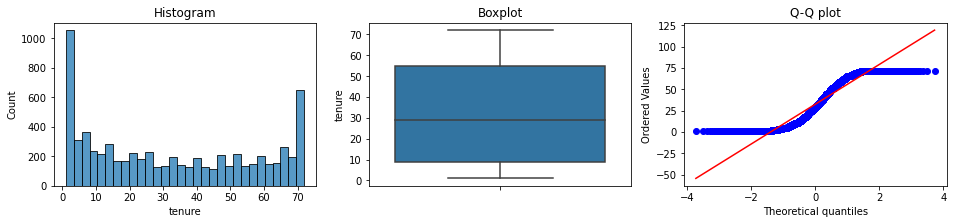

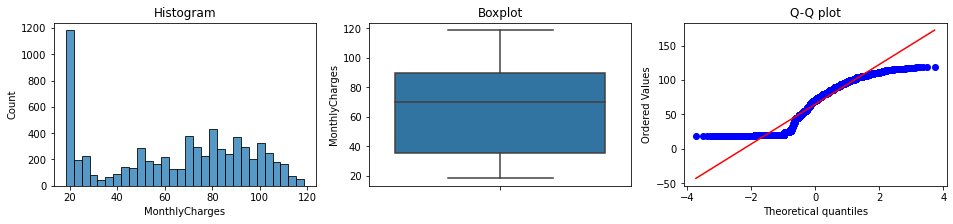

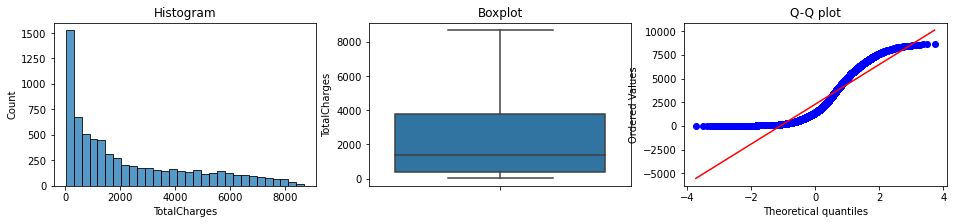

In [25]:
for var in quan_var:
    diagnostic_plots(df,var)

Count plot for gender


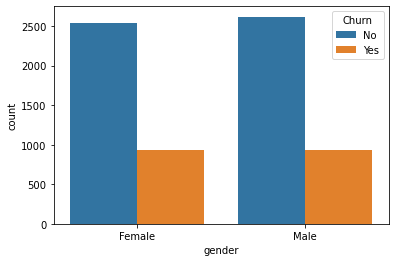

Count plot for SeniorCitizen


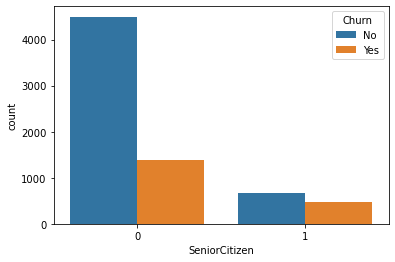

Count plot for Partner


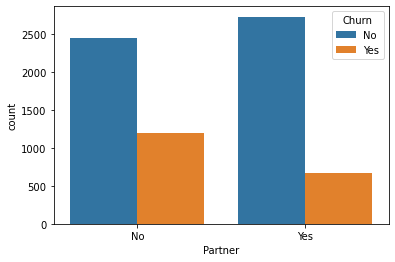

Count plot for Dependents


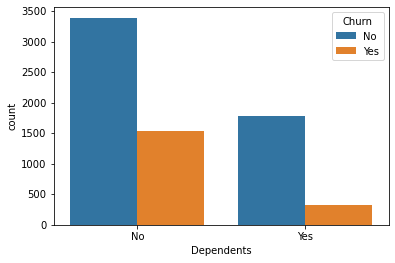

Count plot for PhoneService


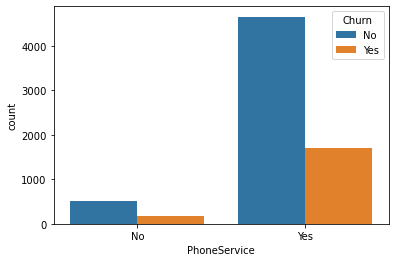

Count plot for MultipleLines


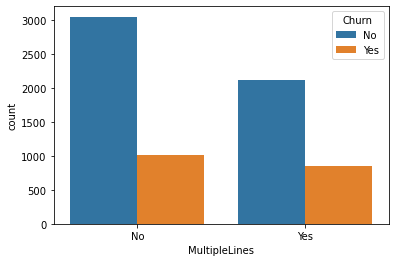

Count plot for InternetService


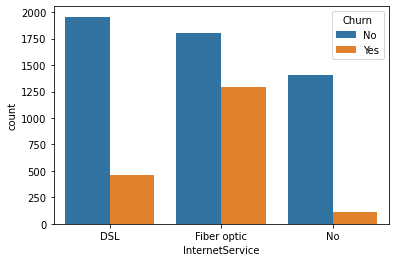

Count plot for OnlineSecurity


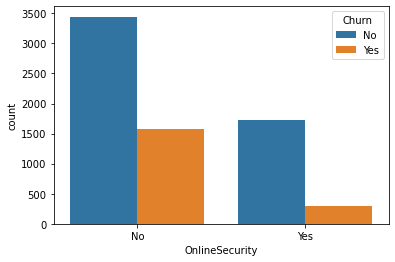

Count plot for OnlineBackup


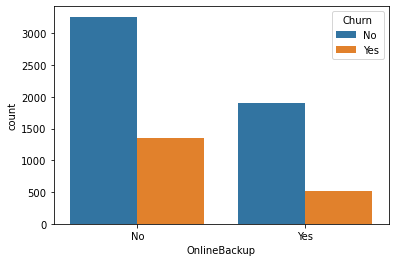

Count plot for DeviceProtection


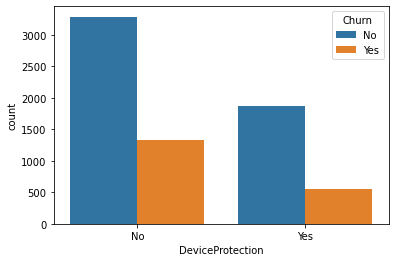

Count plot for TechSupport


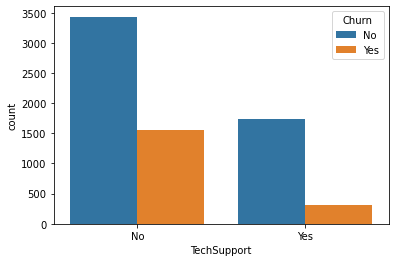

Count plot for StreamingTV


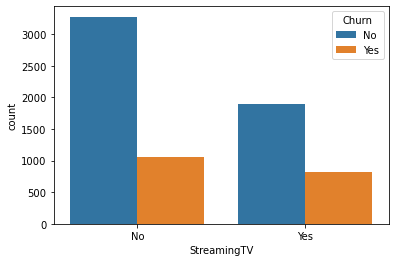

Count plot for StreamingMovies


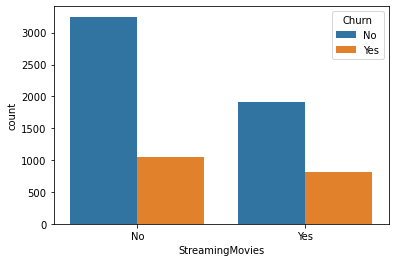

Count plot for Contract


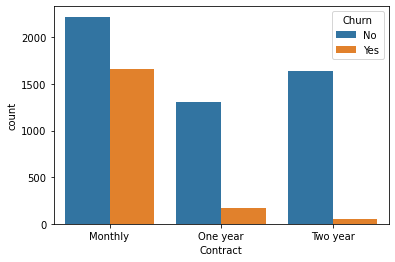

Count plot for PaperlessBilling


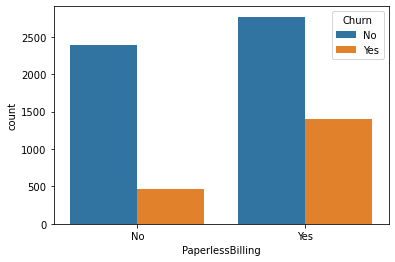

Count plot for PaymentMethod


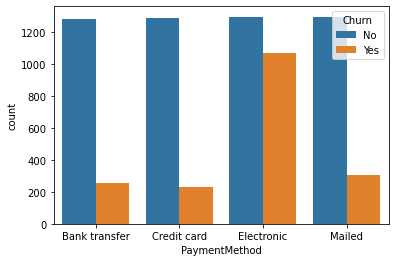

In [26]:
for var in qual_var:
    print(f"Count plot for {var}")
    ax = sns.countplot(x=df[var], hue=df['Churn'])
    plt.show()

### Observations
* *Gender distribution shows there relatively equal number of Male and Female who stayed with the provider and who choose to discontinue the service*<br>
* *Most of the customers are not Senior Citizens*<br>
* *Customers who have partners are marginally higher than customers who don\'t. And customer who have dependents are relatively lower than customers who don\'t.*<br>
* *Most of the customers uses Phone Service, does not have multiple lines, uses either DSL or Fiber optics, and have internet services*<br>
* *While most customers are on monthly plans, there\'s almost equal distribution of customers on long term plans.*<br>
* *Most customers prefer paperless billing and uses Electronic mode of payment. Also, the customers who churned are most in this segment.*<br>

### Correlation between independent variables

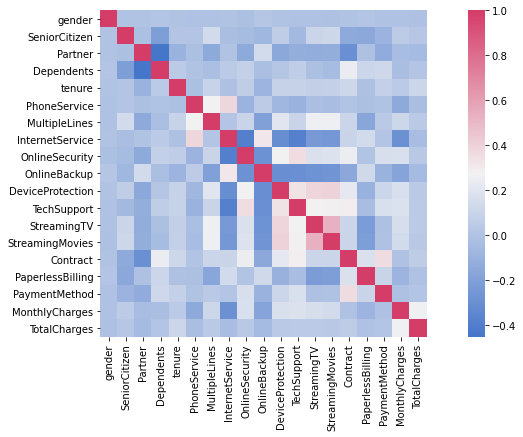

In [27]:
corr = df.drop(columns=['Churn']).apply(lambda x : pd.factorize(x)[0]).corr(method='pearson')
plt.figure(figsize=(15,6))
cmap = sns.diverging_palette(255, 0, as_cmap=True)
sns.heatmap(corr, square=True, cmap=cmap)
plt.show()

*We can see that none of the independent variables have a very high correlation. StreamingTV and StreamMovies have maximum correlation of 0.53.*

### Correlation between quantitative variables

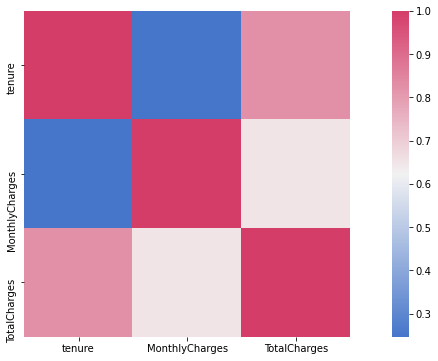

In [28]:
corr_quan = df[quan_var].corr()
plt.figure(figsize=(15,6))
cmap = sns.diverging_palette(255, 0, as_cmap=True)
sns.heatmap(corr_quan, square=True, cmap=cmap)
plt.show()

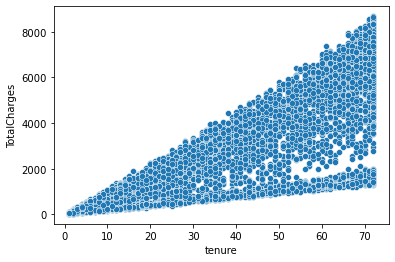

In [29]:
sns.scatterplot(x= df['tenure'], y=df['TotalCharges'])
plt.show()

### Check for outliers in quantitative variables

In [30]:
df[quan_var].describe()

,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441
std,24.545260,30.085974,2266.771362
min,1.000000,18.250000,18.800000
25%,9.000000,35.587500,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.862500,3794.737500
max,72.000000,118.750000,8684.800000


In [31]:
Q1 = df[quan_var].quantile(0.25)
Q3 = df[quan_var].quantile(0.75)
IQR = Q3 - Q1
((df[quan_var] < Q1 - (1.5 * IQR)) | (df[quan_var] > Q3 + (1.5 * IQR))).any()

tenure            False
MonthlyCharges    False
TotalCharges      False
dtype: bool

In [32]:
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

### Learning Curve Function

In [33]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.2, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True,
                       random_state=123)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    return plt

### Functions for metrics

In [34]:
def confusion_matrix_plot(X_test, y_test, classifier, classifier_name):
    fig, ax = plt.subplots(figsize=(7, 6))
    plot_confusion_matrix(classifier, X_test, y_test, display_labels=["No Churn", "Churn"], cmap=plt.cm.Blues, normalize=None, ax=ax)
    ax.set_title(f'{classifier_name} - Confusion Matrix')
    plt.show()
    fig, ax = plt.subplots(figsize=(7, 6))
    plot_confusion_matrix(classifier, X_test, y_test, display_labels=["No Churn", "Churn"], cmap=plt.cm.Blues, normalize='true', ax=ax)
    ax.set_title(f'{classifier_name} - Confusion Matrix (norm.)')
    plt.show()
def roc_curve_plot(X_test, y_test, classifier, classifier_name):
    y_pred_prob = classifier.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label=f'{classifier_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{classifier_name} - ROC Curve')
    plt.show()
def metrics(X_train, y_train, X_test, y_test, y_pred, y_prob, classifier, classifier_name):
    print(f'{classifier_name} Metrics')
    acc_train = classifier.score(X_train, y_train)
    acc_test = classifier.score(X_test, y_test)
    pre_test = precision_score(y_test, y_pred)
    rec_test = recall_score(y_test, y_pred)
    roc_test = roc_auc_score(y_test, y_prob[:, 1])
    f1_test = f1_score(y_test, y_pred)
    precision, recall, thresholds = precision_recall_curve(y_test, y_prob[:, 1])
    auc_test = auc(recall, precision)
    print(f'Accuracy (Train): {acc_train}')
    print(f'Accuracy (Test): {acc_test}')
    print(f'Precision (Test): {pre_test}')
    print(f'Recall (Test): {rec_test}')
    print(f'ROC AUC Score (Test): {roc_test}')
    print(f'F1 Score (Test): {f1_test}')
    print(f'AUC Score (Test): {auc_test}')
    out = [acc_train, acc_test, pre_test, rec_test, roc_test, f1_test, auc_test]
    return out
def precision_recall_curve_and_scores(X_test, y_test, y_pred, y_prob, classifier_name):
    precision, recall, thresholds = precision_recall_curve(y_test, y_prob[:, 1])
    plt.plot(recall, precision, label=f'{classifier_name}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{classifier_name} - Precision-Recall Curve')
    plt.show()
def feature_weights(X_df, classifier, classifier_name):
    weights = pd.Series(classifier.best_estimator_.coef_[0], index=X_df.columns.values).sort_values(ascending=False)
    
    top_weights_selected = weights[:10]
    plt.figure(figsize=(7,6))
    plt.tick_params(labelsize=10)#plt.xlabel(fontsize=10)
    plt.title(f'{classifier_name} - Top 10 Features')
    top_weights_selected.plot(kind="bar")
    
    bottom_weights_selected = weights[-10:]
    plt.figure(figsize=(7,6))
    plt.tick_params(labelsize=10)#plt.xlabel(fontsize=10)
    plt.title(f'{classifier_name} - Bottom 10 Features')
    bottom_weights_selected.plot(kind="bar")
    
    return print("")

### Train Test Split

In [35]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Churn']), df['Churn'], test_size=0.2, random_state=100, stratify = df['Churn'])

#### Preprocessing

In [36]:
encoder = OneHotEncoder(drop_last=True, variables=qual_var)
tf = vt.YeoJohnsonTransformer(variables=quan_var)
scaler = SklearnTransformerWrapper(transformer=MinMaxScaler(), variables=quan_var)

In [37]:
encoder.fit(X_train)
X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)

In [38]:
tf.fit(X_train)
X_train = tf.transform(X_train)
X_test = tf.transform(X_test)

In [39]:
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Logit Model

In [40]:
X_train_c = sm.add_constant(X_train)
logit_model = sm.Logit(y_train,X_train_c)
result = logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.406515
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                 5625
Model:                          Logit   Df Residuals:                     5601
Method:                           MLE   Df Model:                           23
Date:                Sun, 12 Dec 2021   Pseudo R-squ.:                  0.2979
Time:                        01:31:32   Log-Likelihood:                -2286.6
converged:                       True   LL-Null:                       -3257.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -1.6068      0.842     -1.908      0.056   

8 iterations has been done to find the optimized model<br>
coef : the coefficients of the independent variables in the regression equation.<br>
Log-Likelihood : the natural logarithm of the Maximum Likelihood Estimation(MLE) function. MLE is the optimization process of finding the set of parameters that result in the best fit.<br>
LL-Null : the value of log-likelihood of the model when no independent variable is included(only an intercept is included).<br>
Pseudo R-squ. : a substitute for the R-squared value in Least Squares linear regression. It is the ratio of the log-likelihood of the null model to that of the full model.<br>

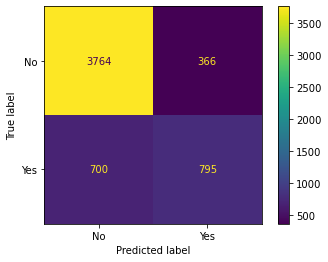

Accuracy: 0.8104888888888889
Precision: 0.6847545219638242
Recall: 0.5317725752508361
F1 Score: 0.5986445783132529
ROC AUC: 0.7215763602646431


In [41]:
prediction = list(map(round, result.predict(sm.add_constant(X_train))))
ConfusionMatrixDisplay(confusion_matrix(y_train, prediction), display_labels=['No','Yes']).plot()
plt.show()
print(f'Accuracy: {accuracy_score(y_train, prediction)}')
print(f'Precision: {precision_score(y_train, prediction)}')
print(f'Recall: {recall_score(y_train, prediction)}')
print(f'F1 Score: {f1_score(y_train, prediction)}')
print(f'ROC AUC: {roc_auc_score(y_train, prediction)}')

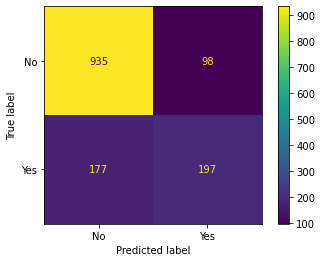

Accuracy: 0.8045486851457001
Precision: 0.6677966101694915
Recall: 0.5267379679144385
F1 Score: 0.5889387144992526
ROC AUC: 0.7159343276164642


In [42]:
prediction = list(map(round, result.predict(sm.add_constant(X_test))))
ConfusionMatrixDisplay(confusion_matrix(y_test, prediction), display_labels=['No','Yes']).plot()
plt.show()
print(f'Accuracy: {accuracy_score(y_test, prediction)}')
print(f'Precision: {precision_score(y_test, prediction)}')
print(f'Recall: {recall_score(y_test, prediction)}')
print(f'F1 Score: {f1_score(y_test, prediction)}')
print(f'ROC AUC: {roc_auc_score(y_test, prediction)}')

In [43]:
np.unique(y_train, return_counts=True)

(array([0, 1], dtype=int64), array([4130, 1495], dtype=int64))

In [44]:
smote = SMOTE(random_state=123)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [45]:
np.unique(y_train_res, return_counts=True)

(array([0, 1], dtype=int64), array([4130, 4130], dtype=int64))

### Logit after oversampling

In [46]:
X_train_res_c = sm.add_constant(X_train_res)
logit_model_os = sm.Logit(y_train_res,X_train_res_c)
result1 = logit_model_os.fit()
print(result1.summary())

Optimization terminated successfully.
         Current function value: 0.464433
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                 8260
Model:                          Logit   Df Residuals:                     8236
Method:                           MLE   Df Model:                           23
Date:                Sun, 12 Dec 2021   Pseudo R-squ.:                  0.3300
Time:                        01:31:32   Log-Likelihood:                -3836.2
converged:                       True   LL-Null:                       -5725.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -0.4076      0.286     -1.426      0.154   

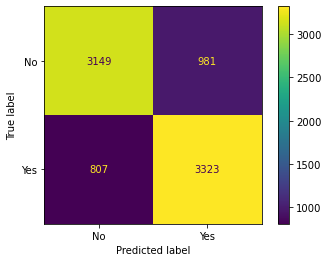

Accuracy: 0.7835351089588378
Precision: 0.7720724907063197
Recall: 0.8046004842615012
F1 Score: 0.7880009485416173
ROC AUC: 0.7835351089588378


In [47]:
prediction = list(map(round, result1.predict(sm.add_constant(X_train_res))))
#print(prediction)
ConfusionMatrixDisplay(confusion_matrix(y_train_res, prediction), display_labels=['No','Yes']).plot()
plt.show()
print(f'Accuracy: {accuracy_score(y_train_res, prediction)}')
print(f'Precision: {precision_score(y_train_res, prediction)}')
print(f'Recall: {recall_score(y_train_res, prediction)}')
print(f'F1 Score: {f1_score(y_train_res, prediction)}')
print(f'ROC AUC: {roc_auc_score(y_train_res, prediction)}')

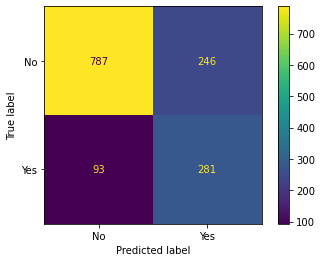

Accuracy: 0.7590618336886994
Precision: 0.5332068311195446
Recall: 0.7513368983957219
F1 Score: 0.6237513873473918
ROC AUC: 0.7565977812404554


In [48]:
prediction = list(map(round, result1.predict(sm.add_constant(X_test))))
#print(prediction)
ConfusionMatrixDisplay(confusion_matrix(y_test, prediction), display_labels=['No','Yes']).plot()
plt.show()
print(f'Accuracy: {accuracy_score(y_test, prediction)}')
print(f'Precision: {precision_score(y_test, prediction)}')
print(f'Recall: {recall_score(y_test, prediction)}')
print(f'F1 Score: {f1_score(y_test, prediction)}')
print(f'ROC AUC: {roc_auc_score(y_test, prediction)}')

#### KNN Classifier

In [49]:
knn = KNeighborsClassifier()
knn.fit(X_train_res, y_train_res)
y_pred_knn = knn.predict(X_test)
y_pred_knn_prob = knn.predict_proba(X_test)

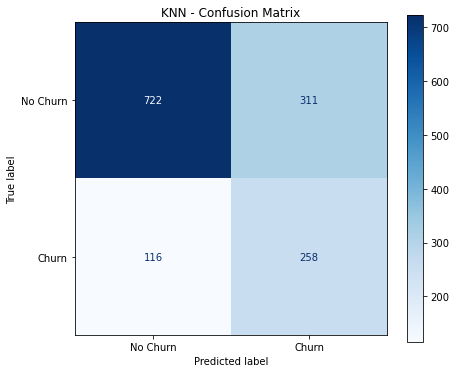

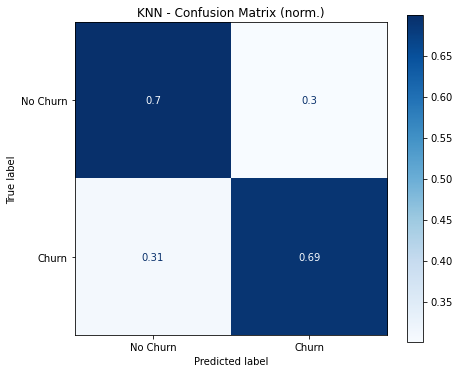

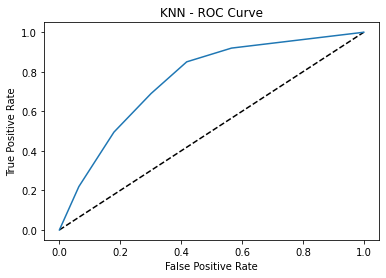

KNN Metrics
Accuracy (Train): 0.8647699757869249
Accuracy (Test): 0.6965174129353234
Precision (Test): 0.45342706502636204
Recall (Test): 0.6898395721925134
ROC AUC Score (Test): 0.7580136252336014
F1 Score (Test): 0.5471898197242843
AUC Score (Test): 0.5320893502462791


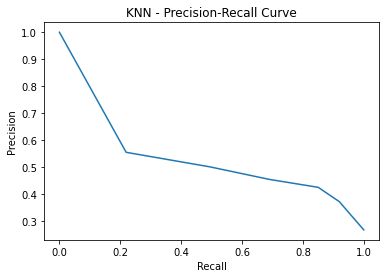

In [50]:
warnings.filterwarnings('ignore')
confusion_matrix_plot(X_test, y_test, knn, 'KNN')
roc_curve_plot(X_test, y_test, knn, 'KNN')
metrics(X_train_res, y_train_res, X_test, y_test, y_pred_knn, y_pred_knn_prob, knn, 'KNN')
precision_recall_curve_and_scores(X_test, y_test, y_pred_knn, y_pred_knn_prob, 'KNN')

#### Logistic Regression

In [51]:
warnings.filterwarnings('ignore')
logreg = LogisticRegression()
logreg.fit(X_train_res, y_train_res)
y_pred_logreg = logreg.predict(X_test)
y_pred_logreg_prob = logreg.predict_proba(X_test)

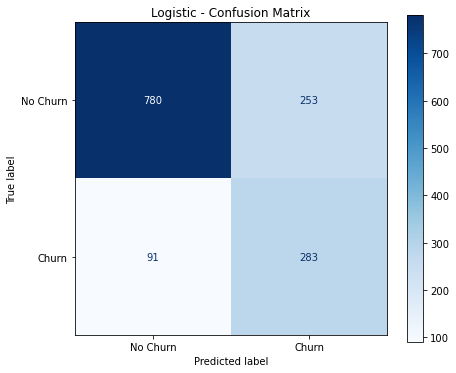

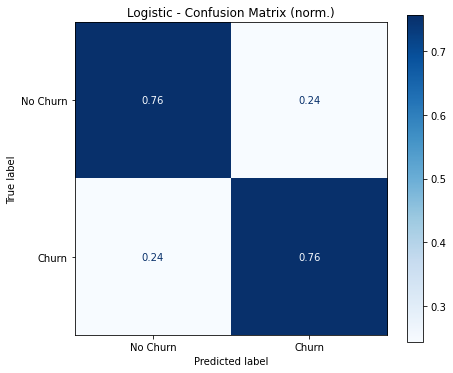

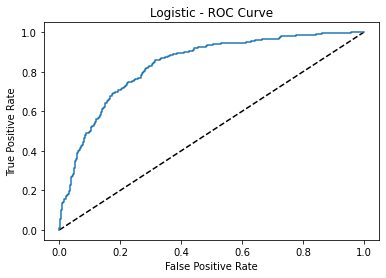

Logistic Metrics
Accuracy (Train): 0.7807506053268766
Accuracy (Test): 0.7555081734186212
Precision (Test): 0.5279850746268657
Recall (Test): 0.7566844919786097
ROC AUC Score (Test): 0.8348043961050055
F1 Score (Test): 0.621978021978022
AUC Score (Test): 0.6303042928088374


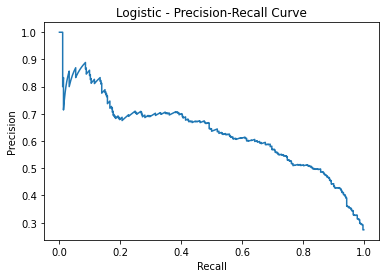

In [52]:
warnings.filterwarnings('ignore')
confusion_matrix_plot(X_test, y_test, logreg, 'Logistic')
roc_curve_plot(X_test, y_test, logreg, 'Logistic')
metrics(X_train_res, y_train_res, X_test, y_test, y_pred_logreg, y_pred_logreg_prob, logreg, 'Logistic')
precision_recall_curve_and_scores(X_test, y_test, y_pred_logreg, y_pred_logreg_prob, 'Logistic')

In [53]:
coeff = pd.DataFrame(np.vstack([X_train_res.columns,logreg.coef_]).T,columns=['Variables','Coefficients'])
intercept = pd.DataFrame(np.vstack(["Intercept",logreg.intercept_]).T,columns=['Variables','Coefficients'])
pd.concat([intercept,coeff],axis=0).reset_index().drop(columns=['index'])

,Variables,Coefficients
0,Intercept,0.085135478685515
1,tenure,-1.532292
2,MonthlyCharges,2.929326
3,TotalCharges,-2.055969
4,gender_Female,-0.181871
5,SeniorCitizen_0,-0.393504
6,Partner_Yes,-0.118414
7,Dependents_Yes,-0.339725
8,PhoneService_No,0.98242
9,MultipleLines_No,-0.383154


#### Decision Tree

In [54]:
dt = DecisionTreeClassifier()
dt.fit(X_train_res, y_train_res)
y_pred_dt = dt.predict(X_test)
y_pred_dt_prob = dt.predict_proba(X_test)

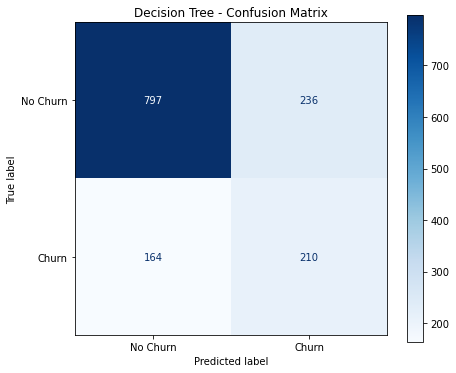

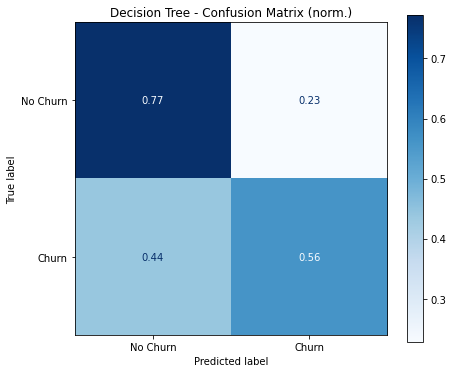

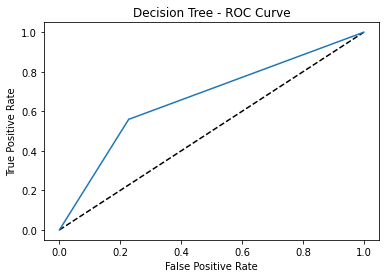

Decision Tree Metrics
Accuracy (Train): 0.9983050847457627
Accuracy (Test): 0.7157071783937455
Precision (Test): 0.47085201793721976
Recall (Test): 0.5614973262032086
ROC AUC Score (Test): 0.6658815246594986
F1 Score (Test): 0.5121951219512195
AUC Score (Test): 0.5737649347907166


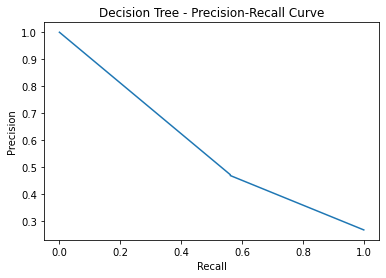

In [55]:
warnings.filterwarnings('ignore')
confusion_matrix_plot(X_test, y_test, dt, 'Decision Tree')
roc_curve_plot(X_test, y_test, dt, 'Decision Tree')
metrics(X_train_res, y_train_res, X_test, y_test, y_pred_dt, y_pred_dt_prob, dt, 'Decision Tree')
precision_recall_curve_and_scores(X_test, y_test, y_pred_dt, y_pred_dt_prob, 'Decision Tree')

#### Random Forest

In [56]:
rf = RandomForestClassifier()
rf.fit(X_train_res, y_train_res)
y_pred_rf = rf.predict(X_test)
y_pred_rf_prob = rf.predict_proba(X_test)

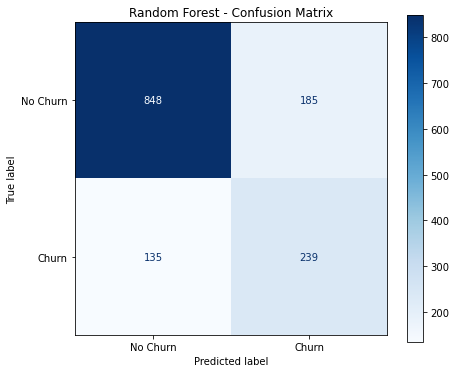

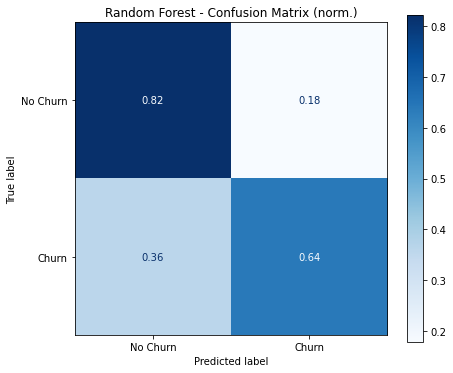

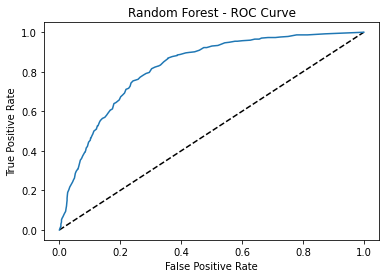

Random Forest Metrics
Accuracy (Train): 0.9983050847457627
Accuracy (Test): 0.7725657427149965
Precision (Test): 0.5636792452830188
Recall (Test): 0.6390374331550802
ROC AUC Score (Test): 0.8216489535178676
F1 Score (Test): 0.5989974937343358
AUC Score (Test): 0.5816617720410047


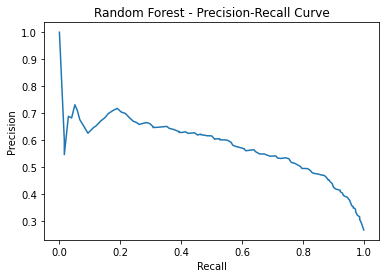

In [57]:
warnings.filterwarnings('ignore')
confusion_matrix_plot(X_test, y_test, rf, 'Random Forest')
roc_curve_plot(X_test, y_test, rf, 'Random Forest')
metrics(X_train_res, y_train_res, X_test, y_test, y_pred_rf, y_pred_rf_prob, rf, 'Random Forest')
precision_recall_curve_and_scores(X_test, y_test, y_pred_rf, y_pred_rf_prob, 'Random Forest')

### Hyperparameter tuning

#### KNN Classifier

In [58]:
param_grid_knn = {"n_neighbors": np.arange(1,30)}
knn = KNeighborsClassifier()
knn = GridSearchCV(knn, param_grid_knn, cv = 5, return_train_score=True)
#knn = RandomizedSearchCV(knn, param_grid_knn, cv = 5, return_train_score=True, n_jobs=-1, random_state=123, n_iter= 100)
knn.fit(X_train_res, y_train_res)
y_pred_knn = knn.predict(X_test)
y_pred_knn_prob = knn.predict_proba(X_test)

Best Estimator: KNeighborsClassifier(n_neighbors=1)


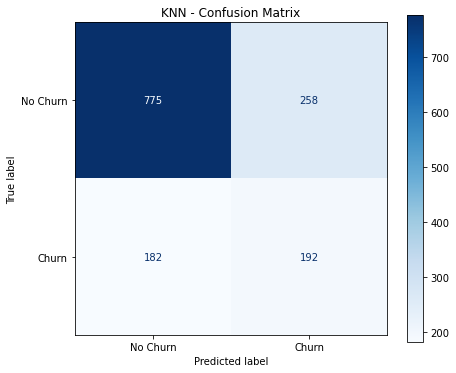

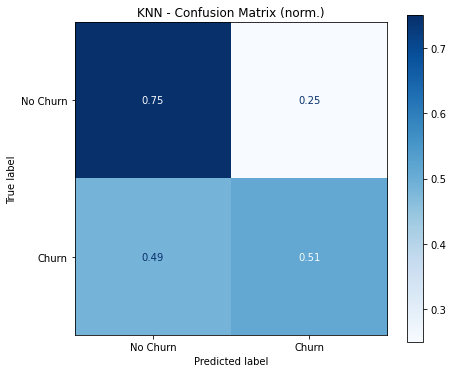

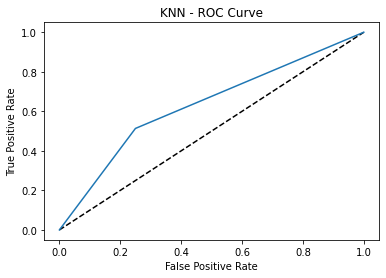

KNN Metrics
Accuracy (Train): 0.9981840193704601
Accuracy (Test): 0.6872778962331201
Precision (Test): 0.4266666666666667
Recall (Test): 0.5133689839572193
ROC AUC Score (Test): 0.6318054987549891
F1 Score (Test): 0.46601941747572817
AUC Score (Test): 0.5346944422273658


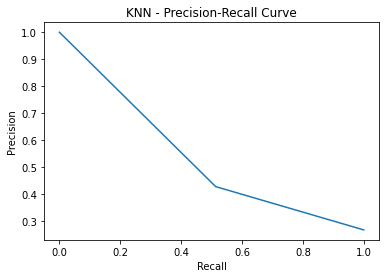

<module 'matplotlib.pyplot' from 'C:\\Users\\vxk200033\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

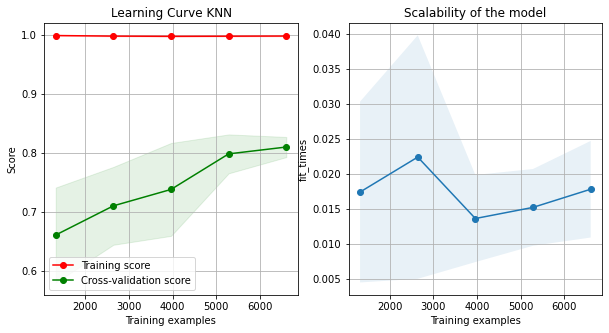

In [59]:
warnings.filterwarnings('ignore')
print(f'Best Estimator: {knn.best_estimator_}')
confusion_matrix_plot(X_test, y_test, knn, 'KNN')
roc_curve_plot(X_test, y_test, knn, 'KNN')
metrics(X_train_res, y_train_res, X_test, y_test, y_pred_knn, y_pred_knn_prob, knn, 'KNN')
precision_recall_curve_and_scores(X_test, y_test, y_pred_knn, y_pred_knn_prob, 'KNN')
plot_learning_curve(knn.best_estimator_,'Learning Curve KNN',X_train_res,y_train_res,n_jobs=-1)

#### Logistic Regression

In [60]:
warnings.filterwarnings('ignore')
param_grid_logreg = {"penalty": ['l1', 'l2'], 
                     "C": np.arange(.1, 5, .1), 
                     "max_iter": np.logspace(0,3,4)}
logreg = LogisticRegression(random_state=123)
logreg = GridSearchCV(logreg, param_grid_logreg, cv = 5, return_train_score=True)
#logreg = RandomizedSearchCV(logreg, param_grid_logreg, cv = 5, return_train_score=True, n_jobs=-1, random_state=123, n_iter= 100)
logreg.fit(X_train_res, y_train_res)
y_pred_logreg = logreg.predict(X_test)
y_pred_logreg_prob = logreg.predict_proba(X_test)

Best Estimator: LogisticRegression(C=0.2, max_iter=10.0, random_state=123)


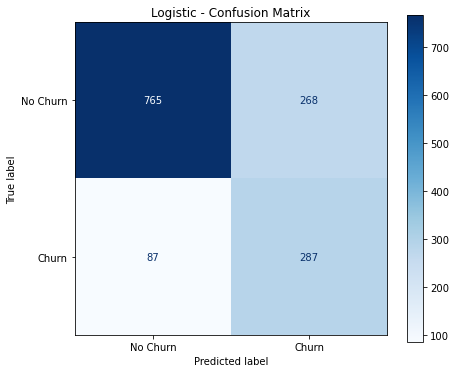

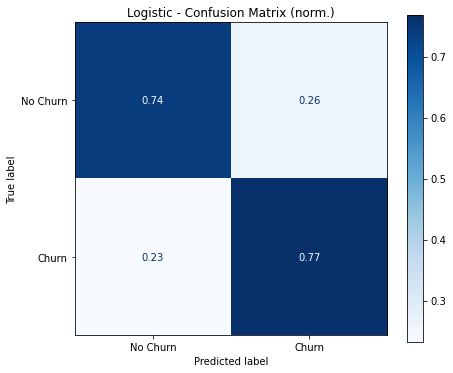

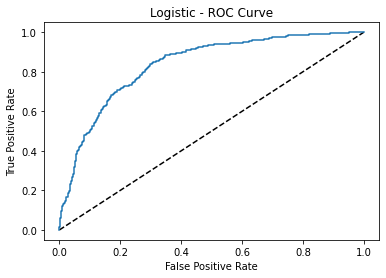

Logistic Metrics
Accuracy (Train): 0.7815980629539951
Accuracy (Test): 0.7476901208244492
Precision (Test): 0.5171171171171172
Recall (Test): 0.767379679144385
ROC AUC Score (Test): 0.8352935999710103
F1 Score (Test): 0.6178686759956943
AUC Score (Test): 0.6292278843771685


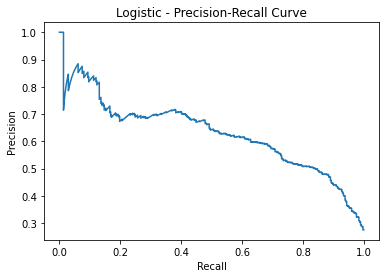

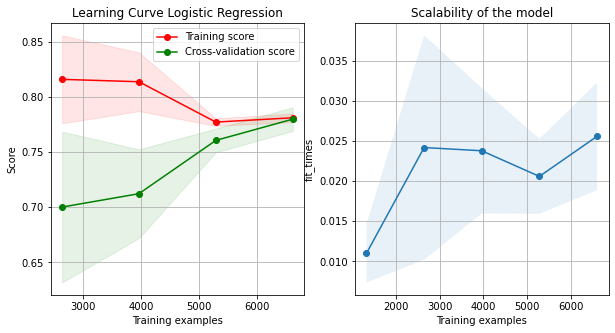

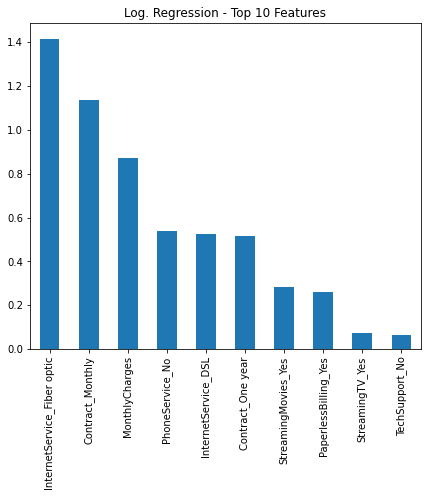

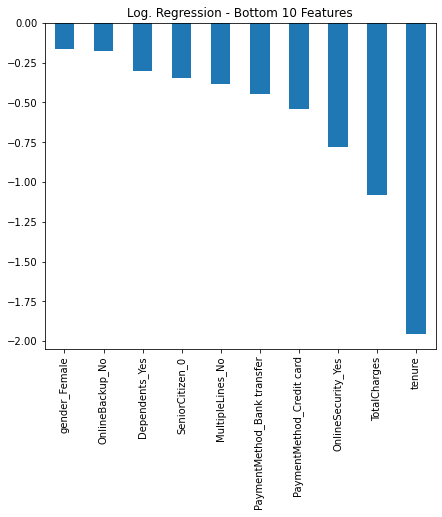

In [61]:
print(f'Best Estimator: {logreg.best_estimator_}')
confusion_matrix_plot(X_test, y_test, logreg, 'Logistic')
roc_curve_plot(X_test, y_test, logreg, 'Logistic')
metrics(X_train_res, y_train_res, X_test, y_test, y_pred_logreg, y_pred_logreg_prob, logreg, 'Logistic')
precision_recall_curve_and_scores(X_test, y_test, y_pred_logreg, y_pred_logreg_prob, 'Logistic')
plot_learning_curve(logreg.best_estimator_,'Learning Curve Logistic Regression',X_train_res,y_train_res,n_jobs=-1)
feature_weights(X_train_res, logreg, 'Log. Regression')

In [62]:
coeff = pd.DataFrame(np.vstack([X_train_res.columns,logreg.best_estimator_.coef_]).T,columns=['Variables','Coefficients'])
intercept = pd.DataFrame(np.vstack(["Intercept",logreg.best_estimator_.intercept_]).T,columns=['Variables','Coefficients'])
pd.concat([intercept,coeff],axis=0).reset_index().drop(columns=['index'])

,Variables,Coefficients
0,Intercept,0.07447872496983063
1,tenure,-1.952358
2,MonthlyCharges,0.86888
3,TotalCharges,-1.082789
4,gender_Female,-0.165528
5,SeniorCitizen_0,-0.343683
6,Partner_Yes,-0.10968
7,Dependents_Yes,-0.304653
8,PhoneService_No,0.537331
9,MultipleLines_No,-0.381628


#### Decision Tree

In [63]:
warnings.filterwarnings('ignore')
param_grid_dt = {"max_depth": np.arange(2,40,2), 
                 "min_samples_leaf": np.arange(2,40,2), 
                 "min_samples_split": np.arange(2,40,2), 
                 "max_leaf_nodes": np.arange(2,40,2),
                 "min_impurity_decrease": np.logspace(-5,0,10)}
dt = DecisionTreeClassifier(random_state=123)
#dt = GridSearchCV(dt, param_grid_dt, cv = 5, return_train_score=True)
dt = RandomizedSearchCV(dt, param_grid_dt, cv = 5, return_train_score=True, n_jobs=-1, random_state=123, n_iter= 100)
dt.fit(X_train_res, y_train_res)
y_pred_dt = dt.predict(X_test)
y_pred_dt_prob = dt.predict_proba(X_test)

Best Estimator: DecisionTreeClassifier(max_depth=6, max_leaf_nodes=30,
                       min_impurity_decrease=3.5938136638046256e-05,
                       min_samples_leaf=34, min_samples_split=24,
                       random_state=123)


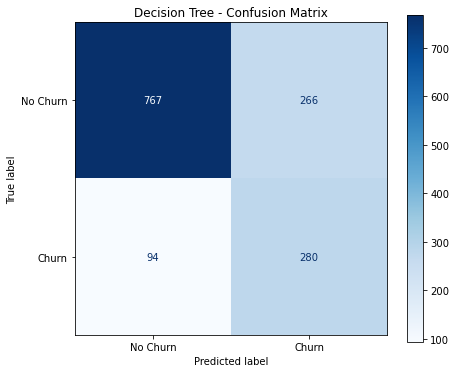

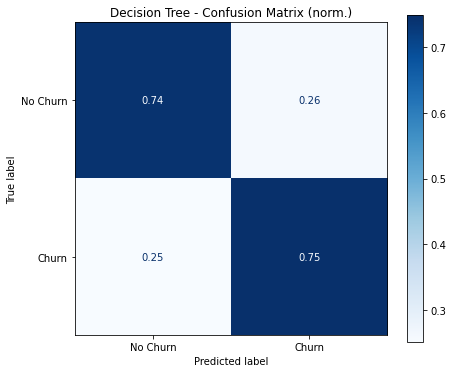

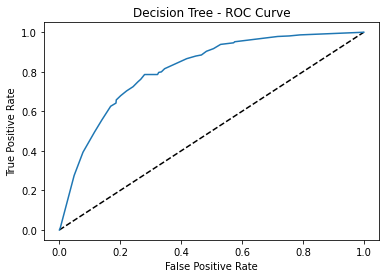

Decision Tree Metrics
Accuracy (Train): 0.7880145278450363
Accuracy (Test): 0.744136460554371
Precision (Test): 0.5128205128205128
Recall (Test): 0.7486631016042781
ROC AUC Score (Test): 0.8144856111942269
F1 Score (Test): 0.6086956521739131
AUC Score (Test): 0.5640357839619452


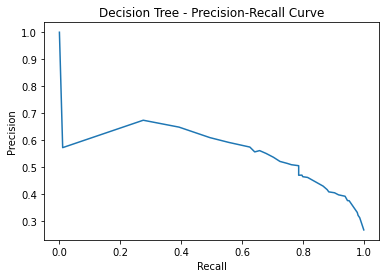

<module 'matplotlib.pyplot' from 'C:\\Users\\vxk200033\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

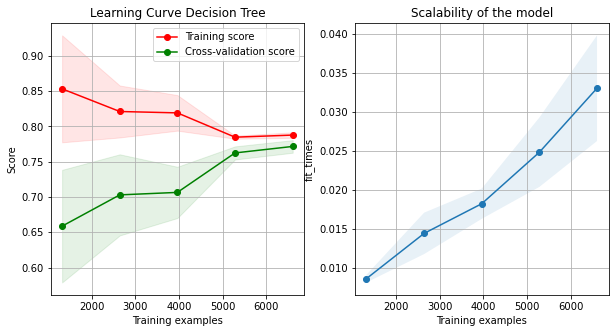

In [64]:
print(f'Best Estimator: {dt.best_estimator_}')
confusion_matrix_plot(X_test, y_test, dt, 'Decision Tree')
roc_curve_plot(X_test, y_test, dt, 'Decision Tree')
metrics(X_train_res, y_train_res, X_test, y_test, y_pred_dt, y_pred_dt_prob, dt, 'Decision Tree')
precision_recall_curve_and_scores(X_test, y_test, y_pred_dt, y_pred_dt_prob, 'Decision Tree')
plot_learning_curve(dt.best_estimator_,'Learning Curve Decision Tree',X_train_res,y_train_res,n_jobs=-1)

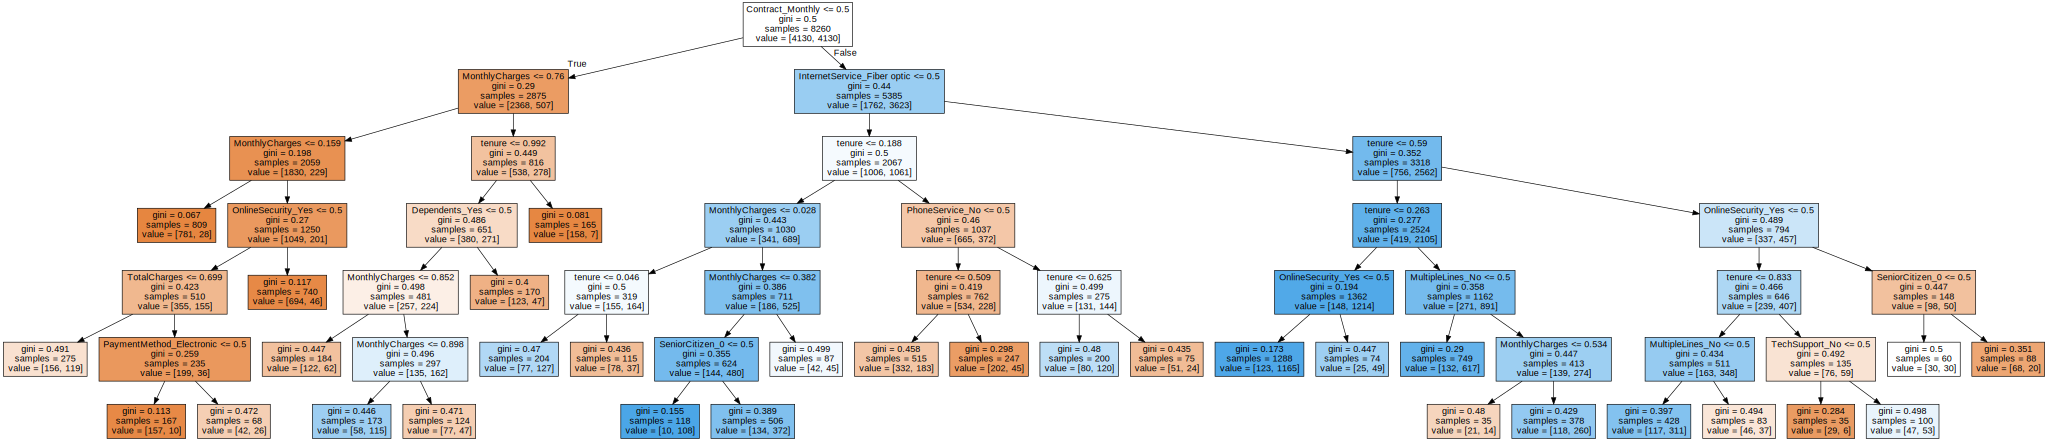

In [65]:
tree_dot = export_graphviz(dt.best_estimator_, out_file=None, feature_names=X_train_res.columns, filled=True)
graph = graphviz.Source(tree_dot, format="png")
graph

#### Random Forest

In [66]:
warnings.filterwarnings('ignore')
param_grid_rf = {'max_depth':np.arange(2,40,2),
                 'n_estimators': np.arange(10,200,10),
                 'min_samples_leaf': np.arange(2,15,2),
                 'max_leaf_nodes': np.arange(5,50,5)}
rf = RandomForestClassifier(random_state=123)
#rf = GridSearchCV(rf, param_grid_rf, cv = 5, return_train_score=True)
rf = RandomizedSearchCV(rf, param_grid_rf, cv = 5, return_train_score=True, n_jobs=-1, random_state=123, n_iter= 100)
rf.fit(X_train_res, y_train_res)
y_pred_rf = rf.predict(X_test)
y_pred_rf_prob = rf.predict_proba(X_test)

Best Estimator: RandomForestClassifier(max_depth=28, max_leaf_nodes=45, min_samples_leaf=4,
                       n_estimators=30, random_state=123)


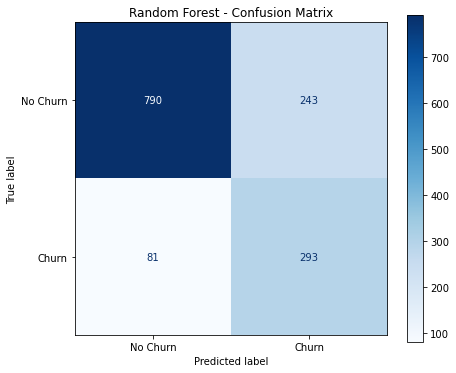

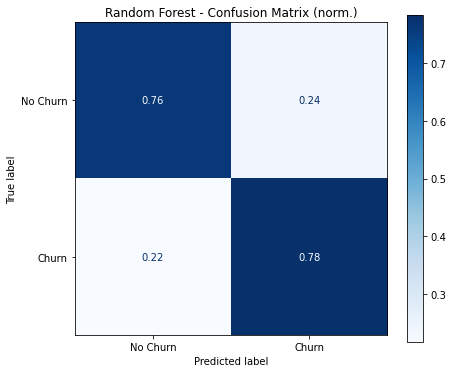

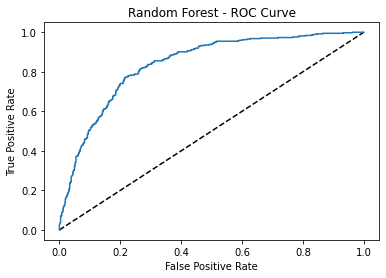

Random Forest Metrics
Accuracy (Train): 0.7991525423728814
Accuracy (Test): 0.7697228144989339
Precision (Test): 0.5466417910447762
Recall (Test): 0.7834224598930482
ROC AUC Score (Test): 0.83805540169073
F1 Score (Test): 0.643956043956044
AUC Score (Test): 0.6296991170486503


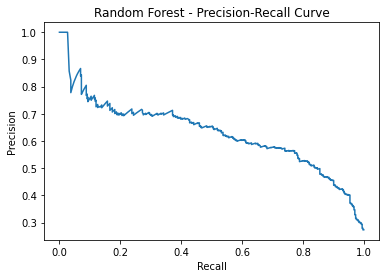

<module 'matplotlib.pyplot' from 'C:\\Users\\vxk200033\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

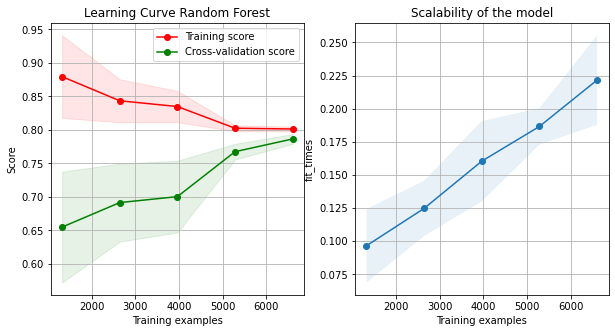

In [67]:
print(f'Best Estimator: {rf.best_estimator_}')
confusion_matrix_plot(X_test, y_test, rf, 'Random Forest')
roc_curve_plot(X_test, y_test, rf, 'Random Forest')
metrics(X_train_res, y_train_res, X_test, y_test, y_pred_rf, y_pred_rf_prob, rf, 'Random Forest')
precision_recall_curve_and_scores(X_test, y_test, y_pred_rf, y_pred_rf_prob, 'Random Forest')
plot_learning_curve(rf.best_estimator_,'Learning Curve Random Forest',X_train_res,y_train_res,n_jobs=-1)

### Model Comparison

In [69]:
%%capture
knn_metric = metrics(X_train_res, y_train_res, X_test, y_test, y_pred_knn, y_pred_knn_prob, knn, 'KNN')
logreg_metric = metrics(X_train_res, y_train_res, X_test, y_test, y_pred_logreg, y_pred_logreg_prob, logreg, 'Logistic')
dt_metric = metrics(X_train_res, y_train_res, X_test, y_test, y_pred_dt, y_pred_dt_prob, dt, 'Decision Tree')
rf_metric = metrics(X_train_res, y_train_res, X_test, y_test, y_pred_rf, y_pred_rf_prob, rf, 'Random Forest')

In [70]:
metric_table = pd.DataFrame({'KNN':knn_metric,
                             'Logistic Regression':logreg_metric,
                             'Decision Tree':dt_metric,
                             'Random Forest':rf_metric}, index=['Accuracy (Train)', 
                                                                'Accuracy (Test)', 
                                                                'Precision (Test)', 
                                                                'Recall (Test)', 
                                                                'ROC AUC Score (Test)', 
                                                                'F1 Score (Test)', 
                                                                'AUC Score (Test)'])

In [71]:
metric_table

,KNN,Logistic Regression,Decision Tree,Random Forest
Accuracy (Train),0.998184,0.781598,0.788015,0.799153
Accuracy (Test),0.687278,0.747690,0.744136,0.769723
Precision (Test),0.426667,0.517117,0.512821,0.546642
Recall (Test),0.513369,0.767380,0.748663,0.783422
ROC AUC Score (Test),0.631805,0.835294,0.814486,0.838055
F1 Score (Test),0.466019,0.617869,0.608696,0.643956
AUC Score (Test),0.534694,0.629228,0.564036,0.629699


{'Contract_Monthly': 0.2622932212927884, 'tenure': 0.16208392851191802, 'MonthlyCharges': 0.11592615524678827, 'InternetService_Fiber optic': 0.10976955030514847, 'TotalCharges': 0.09895295688697806, 'OnlineSecurity_Yes': 0.04256334975049417, 'PaymentMethod_Electronic': 0.034747520546234846, 'Contract_One year': 0.0284557561209496, 'InternetService_DSL': 0.02724281126131248, 'Dependents_Yes': 0.014241761013854999, 'PaymentMethod_Credit card': 0.012819511521837326, 'Partner_Yes': 0.012673255604991916, 'SeniorCitizen_0': 0.012396735679436065, 'MultipleLines_No': 0.011860757902047436, 'PaperlessBilling_Yes': 0.009287412648136468, 'StreamingMovies_Yes': 0.00880804678558707, 'PaymentMethod_Bank transfer': 0.008106277188079884, 'PhoneService_No': 0.006030598606942656, 'TechSupport_No': 0.005698654947428132, 'StreamingTV_Yes': 0.005564086330355475, 'OnlineBackup_No': 0.004977691487013947, 'gender_Female': 0.002952786106929576, 'DeviceProtection_No': 0.002547174254746633}
tenure
MonthlyCharges

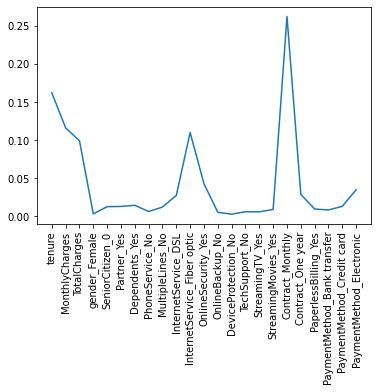

In [104]:
final_model = RandomForestClassifier(max_depth=28, 
                                       max_leaf_nodes=45, 
                                       min_samples_leaf=4, 
                                       n_estimators=30, 
                                       random_state=123)
final_model.fit(X_train_res,y_train_res)
feat_labels = X_train_res.columns

feature_list = {}
for feature,importance in zip(X_train_res.columns, final_model.feature_importances_):
    feature_list[feature] = importance
print(dict(sorted(feature_list.items(), key=lambda item: item[1],reverse=True)))
sfm = SelectFromModel(final_model, threshold=0.10)
sfm.fit(X_train_res, y_train_res)
for feature_list_index in sfm.get_support(indices=True):
    print(feat_labels[feature_list_index])
    
sns.lineplot(x=feature_list.keys(), y=feature_list.values(), data=feature_list)
plt.xticks(rotation=90)
plt.show()

In [96]:
feature_list.keys()

dict_keys(['tenure', 'MonthlyCharges', 'TotalCharges', 'gender_Female', 'SeniorCitizen_0', 'Partner_Yes', 'Dependents_Yes', 'PhoneService_No', 'MultipleLines_No', 'InternetService_DSL', 'InternetService_Fiber optic', 'OnlineSecurity_Yes', 'OnlineBackup_No', 'DeviceProtection_No', 'TechSupport_No', 'StreamingTV_Yes', 'StreamingMovies_Yes', 'Contract_Monthly', 'Contract_One year', 'PaperlessBilling_Yes', 'PaymentMethod_Bank transfer', 'PaymentMethod_Credit card', 'PaymentMethod_Electronic'])

# Confusion matrix threshold tuning

In [72]:
def plot_pr_curve(p, r, thresholds, model_type, dt=[0.5]):

    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title(f'{model_type} | Precision-Recall Curve | Shows Decision Thresholds')
    plt.step(r, p, color='b', alpha=0.2, where='post')
    plt.fill_between(r, p, step='post', alpha=0.2, color='b')
    plt.ylim([0, 1.01])
    plt.xlim([0, 1.01])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    
    # plot the current threshold on the line
    for t in dt:
        dt_point = np.argmin(np.abs(thresholds - t))
        dt_label = 'DT = '+str(t)
        plt.plot(r[dt_point], p[dt_point], 'o', c='k', markersize=12)
        plt.annotate(dt_label, 
                     (r[dt_point], p[dt_point]),
                     textcoords="offset points", 
                     xytext=(0,12), 
                     ha='center')

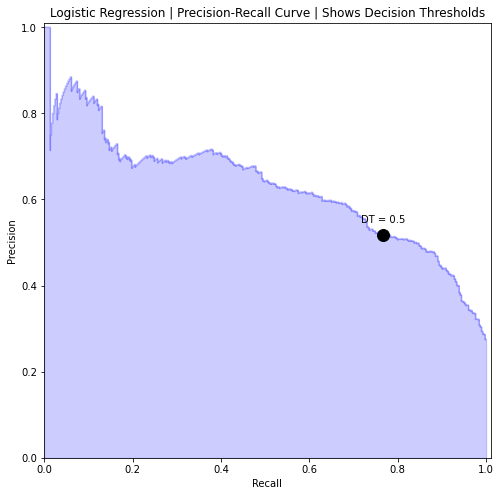

In [73]:
# generate Logistic Regression predict probabilities; store precision-recall curve values
y_pred_logreg_prob_2 = logreg.predict_proba(X_test)[:, 1]
p2, r2, thresholds2 = precision_recall_curve(y_test, y_pred_logreg_prob_2)

# plot precision-recall curve for baseline decision threshold 0.5
plot_pr_curve(p2, r2, thresholds2, 'Logistic Regression', dt=[0.5])

In [74]:
def plot_pr_vs_dt(p, r, thresholds, model_type):
    """
    Plots precision and recall lines (y) for each value of classifier decision
    threshold (x). Default classifier models use >= 0.5.
   
    Parameters:
    - p (array): precision value at certain threshold
    - r (array): recall value at certain threshold
    - thresholds (array): probability threshold where positive class is assigned
    - model_type (str): Text for model type title

    Returns: None
    """
    plt.figure(figsize=(8, 8))
    plt.title(f'{model_type} | Precision-Recall Scores vs. Decision Threshold')
    plt.plot(thresholds, p[:-1], 'b--', label='Precision')
    plt.plot(thresholds, r[:-1], 'g-', label='Recall')
    plt.ylabel('Score')
    plt.xlabel('Decision Threshold')
    plt.legend(loc='best')

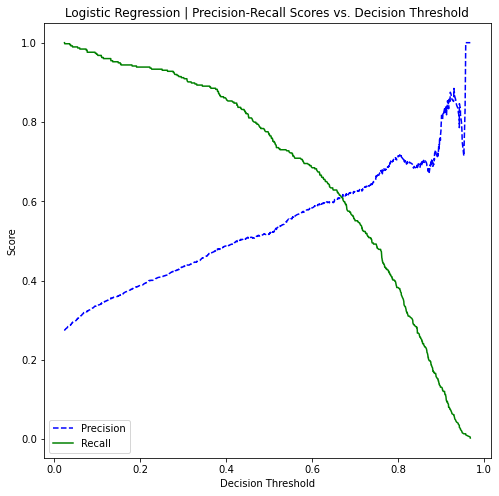

In [75]:
# plot precision and recall against decision threshold options
plot_pr_vs_dt(p2, r2, thresholds2, 'Logistic Regression')

In [76]:
def assign_class(y_hat_prob, dt=0.5):
    """
    Calculates churn predictions based on any decision threshold level 
    using a classification model's predicted probability scores.
    
    Parameters:
    - y_hat_prob (array): predicted churn probabilities
    - dt (float): decision threshold value between 0 and 1. Represents 
      predicted probability at which postive class (churn) should be assigned.

    Returns:
    - scores (dict): includes 5 evaluation metrics for model type
    """
    return [1 if y >= dt else 0 for y in y_hat_prob]

In [77]:
# plot confusion matrix for classifier object
def class1_confusion_matrix_plot(y_true, y_hat):
    """Prints classification report for a classifier model predictions.

    Parameters:
    - y_true (pd.Series): true north y values (actual churn values)
    - y_hat (array): model predictions for y    

    Returns: none
    """
    print(pd.DataFrame(confusion_matrix(y_true, y_hat),
                       columns=['Retain Pred', 'Churn Pred'], 
                       index=['Retain Actual', 'Churn Actual']))
    print(classification_report(y_true, y_hat))

In [78]:
# revised class predictions using decision threshold 0.5
y_pred_low_2 = assign_class(y_pred_logreg_prob_2, dt=0.5)
# confusion_matrix(y_test, y_pred_adj)
class1_confusion_matrix_plot(y_test, y_pred_low_2)

               Retain Pred  Churn Pred
Retain Actual          765         268
Churn Actual            87         287
              precision    recall  f1-score   support

           0       0.90      0.74      0.81      1033
           1       0.52      0.77      0.62       374

    accuracy                           0.75      1407
   macro avg       0.71      0.75      0.71      1407
weighted avg       0.80      0.75      0.76      1407



In [79]:
# revised class predictions using decision threshold 0.43
y_pred_med_2 = assign_class(y_pred_logreg_prob_2, dt=0.35)
# confusion_matrix(y_test, y_pred_adj)
class1_confusion_matrix_plot(y_test, y_pred_med_2)

               Retain Pred  Churn Pred
Retain Actual          640         393
Churn Actual            41         333
              precision    recall  f1-score   support

           0       0.94      0.62      0.75      1033
           1       0.46      0.89      0.61       374

    accuracy                           0.69      1407
   macro avg       0.70      0.75      0.68      1407
weighted avg       0.81      0.69      0.71      1407



In [80]:
# revised class predictions using decision threshold 0.73
y_pred_hi_2 = assign_class(y_pred_logreg_prob_2, dt=0.23)
# confusion_matrix
class1_confusion_matrix_plot(y_test, y_pred_hi_2)

               Retain Pred  Churn Pred
Retain Actual          512         521
Churn Actual            25         349
              precision    recall  f1-score   support

           0       0.95      0.50      0.65      1033
           1       0.40      0.93      0.56       374

    accuracy                           0.61      1407
   macro avg       0.68      0.71      0.61      1407
weighted avg       0.81      0.61      0.63      1407

